# DNA-binding Protein recognition using the SGT

Sequence Graph Transform (SGT) is used for Sequence Embedding.
<br>
SGT reference: https://github.com/cran2367/sgt
<br>
SGT overview: https://towardsdatascience.com/sequence-embedding-for-clustering-and-classification-f816a66373fb

## All necessary imports

In [1]:
import sgt
from sgt import SGT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

np.random.seed(7)  # for reproducibility
sgt.__version__

'2.0.3'

## Reading the DBP data

In [2]:
# Loading data
df = pd.read_csv('../data_instadeep/dna_binding/train.csv')
print(df.shape)

(14189, 4)


There are 14,189 samples.

In [3]:
df.head(5)

,code,sequence,label,origin
0,Q6A8L0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
1,Q7V7T9,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
2,Q9ZUP2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
3,Q2JVG1,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
4,Q9K4Q3,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...


In [4]:
df.dtypes

code        object
sequence    object
label        int64
origin      object
dtype: object

In [5]:
print(f'{"Column":15s} # of unique values')
print(f'{"-"*40:60s}')
for col in df:
    print(f'{col:15s} {len(df[col].unique())}')

Column          # of unique values
----------------------------------------                    
code            14189
sequence        14016
label           2
origin          1


This data has duplicate sequences.

In [6]:
# Any None entries?
df.isna().sum()

code        0
sequence    0
label       0
origin      0
dtype: int64

In [7]:
# Is the data balanced?
df['label'].value_counts(normalize=True)

1    0.502431
0    0.497569
Name: label, dtype: float64

The data is fairly balanced (note that there are some duplicate values, although not enough to significantly change this balance).

## Protein Sequence Clustering

In [8]:
df.columns

Index(['code', 'sequence', 'label', 'origin'], dtype='object')

In [10]:
# Data preprocessing
df_pca = df.loc[:, ['code', 'sequence']]
print(df_pca.head())

df_pca.columns = ['id', 'sequence']
df_pca['sequence'] = df_pca['sequence'].map(list)
df_pca

     code                                           sequence
0  Q6A8L0  MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...
1  Q7V7T9  MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...
2  Q9ZUP2  MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...
3  Q2JVG1  MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...
4  Q9K4Q3  MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...


,id,sequence
0,Q6A8L0,"[M, S, G, H, S, K, W, A, T, T, K, H, K, K, A, ..."
1,Q7V7T9,"[M, I, G, W, L, Q, G, Q, K, V, E, A, W, Q, Q, ..."
2,Q9ZUP2,"[M, A, R, I, L, R, N, V, Y, S, L, R, S, S, L, ..."
3,Q2JVG1,"[M, K, C, P, R, C, G, K, Q, E, I, R, V, L, E, ..."
4,Q9K4Q3,"[M, T, K, A, D, I, I, E, G, V, Y, E, K, V, G, ..."
...,...,...
14184,P52610,"[M, E, E, K, K, E, K, E, I, L, D, V, S, A, L, ..."
14185,Q0S3H4,"[M, S, T, I, A, D, P, R, D, I, L, L, A, P, V, ..."
14186,A0RQ16,"[M, S, L, E, S, F, D, K, D, I, Y, S, L, V, N, ..."
14187,Q16AE8,"[M, A, L, K, S, Y, K, P, T, T, P, G, Q, R, G, ..."


In [11]:
%%time
# Compute SGT embeddings
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(df_pca)

CPU times: user 23min 48s, sys: 17.5 s, total: 24min 6s
Wall time: 24min 30s


In [12]:
sgtembedding_df

,id,"(A, A)","(A, B)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)",...,"(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, U)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
0,Q6A8L0,0.004632,0.0,4.719703e-04,0.002982,0.002934,0.000185,0.005022,1.831564e-02,0.007323,...,5.080292e-03,5.725063e-04,6.172931e-03,0.002875,3.393118e-03,0.0,0.001254,0.000000e+00,0.0,2.707642e-03
1,Q7V7T9,0.006585,0.0,1.514995e-02,0.001084,0.006826,0.005014,0.006905,1.468161e-03,0.012471,...,3.098440e-04,3.829783e-03,2.070436e-04,0.000002,1.903748e-09,0.0,0.009667,5.578941e-11,0.0,3.917470e-64
2,Q9ZUP2,0.004187,0.0,1.284408e-05,0.003090,0.001433,0.000869,0.000888,5.048510e-03,0.001348,...,3.585891e-03,1.147779e-07,2.580163e-03,0.004559,7.288756e-06,0.0,0.000059,0.000000e+00,0.0,6.079213e-05
3,Q2JVG1,0.000674,0.0,9.197147e-02,0.001916,0.006343,0.001487,0.008993,3.495380e-12,0.000021,...,3.530870e-05,6.110882e-04,2.290180e-02,0.000157,2.838309e-03,0.0,0.011577,9.693826e-22,0.0,1.274971e-03
4,Q9K4Q3,0.019435,0.0,0.000000e+00,0.014301,0.012108,0.000458,0.004399,1.130558e-03,0.021721,...,6.525698e-24,1.114969e-18,2.088366e-13,0.000421,5.247262e-10,0.0,0.007113,0.000000e+00,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14184,P52610,0.004072,0.0,0.000000e+00,0.003497,0.001489,0.001328,0.003370,4.766027e-06,0.002754,...,1.843996e-03,1.583927e-03,2.293819e-03,0.004004,1.314078e-02,0.0,0.000035,0.000000e+00,0.0,2.377479e-22
14185,Q0S3H4,0.000134,0.0,0.000000e+00,0.053928,0.009638,0.000473,0.000680,3.792552e-10,0.003439,...,3.099487e-04,1.536568e-06,3.580181e-03,0.000034,1.954823e-02,0.0,0.001146,0.000000e+00,0.0,1.118209e-04
14186,A0RQ16,0.001324,0.0,5.954292e-04,0.005224,0.003381,0.002444,0.004258,4.440869e-03,0.002419,...,5.686883e-03,6.391712e-04,1.148692e-03,0.002442,2.086170e-05,0.0,0.001255,3.728149e-39,0.0,3.832043e-03
14187,Q16AE8,0.003843,0.0,6.252245e-09,0.004420,0.001330,0.014274,0.002345,5.836962e-05,0.003022,...,3.438873e-03,5.183109e-03,3.122333e-03,0.000042,1.169486e-03,0.0,0.000734,6.225329e-10,0.0,3.426947e-05


This is the embedding generated using the SGT.

In [13]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(A, A)","(A, B)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, U)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
Q6A8L0,0.004632,0.0,4.719703e-04,0.002982,0.002934,0.000185,0.005022,1.831564e-02,0.007323,0.007568,...,5.080292e-03,5.725063e-04,6.172931e-03,0.002875,3.393118e-03,0.0,0.001254,0.000000e+00,0.0,2.707642e-03
Q7V7T9,0.006585,0.0,1.514995e-02,0.001084,0.006826,0.005014,0.006905,1.468161e-03,0.012471,0.000267,...,3.098440e-04,3.829783e-03,2.070436e-04,0.000002,1.903748e-09,0.0,0.009667,5.578941e-11,0.0,3.917470e-64
Q9ZUP2,0.004187,0.0,1.284408e-05,0.003090,0.001433,0.000869,0.000888,5.048510e-03,0.001348,0.003714,...,3.585891e-03,1.147779e-07,2.580163e-03,0.004559,7.288756e-06,0.0,0.000059,0.000000e+00,0.0,6.079213e-05
Q2JVG1,0.000674,0.0,9.197147e-02,0.001916,0.006343,0.001487,0.008993,3.495380e-12,0.000021,0.002702,...,3.530870e-05,6.110882e-04,2.290180e-02,0.000157,2.838309e-03,0.0,0.011577,9.693826e-22,0.0,1.274971e-03
Q9K4Q3,0.019435,0.0,0.000000e+00,0.014301,0.012108,0.000458,0.004399,1.130558e-03,0.021721,0.000009,...,6.525698e-24,1.114969e-18,2.088366e-13,0.000421,5.247262e-10,0.0,0.007113,0.000000e+00,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P52610,0.004072,0.0,0.000000e+00,0.003497,0.001489,0.001328,0.003370,4.766027e-06,0.002754,0.002906,...,1.843996e-03,1.583927e-03,2.293819e-03,0.004004,1.314078e-02,0.0,0.000035,0.000000e+00,0.0,2.377479e-22
Q0S3H4,0.000134,0.0,0.000000e+00,0.053928,0.009638,0.000473,0.000680,3.792552e-10,0.003439,0.003138,...,3.099487e-04,1.536568e-06,3.580181e-03,0.000034,1.954823e-02,0.0,0.001146,0.000000e+00,0.0,1.118209e-04
A0RQ16,0.001324,0.0,5.954292e-04,0.005224,0.003381,0.002444,0.004258,4.440869e-03,0.002419,0.003441,...,5.686883e-03,6.391712e-04,1.148692e-03,0.002442,2.086170e-05,0.0,0.001255,3.728149e-39,0.0,3.832043e-03


We perform PCA on the sequence embeddings and then do k-means clustering.

In [14]:
# Number of components vs explained variance %
nc_all = sgtembedding_df.shape[1] - 1  # = total nc (number of components)
x_nc = []  # nc = no of components
y_ev = []  # ev = explained variance %
for n in range(1, nc_all + 1):
    pca = PCA(n_components=n)
    pca.fit(sgtembedding_df)
    x_nc.append(n)
    y_ev.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'explained variance %')

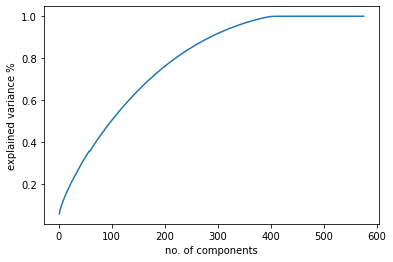

In [15]:
plt.plot(x_nc, y_ev)
plt.xlabel('no. of components')
plt.ylabel('explained variance %')

In [14]:
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)
X=pca.transform(sgtembedding_df)
print(f'Explained variance with only the first 2 components: {np.sum(pca.explained_variance_ratio_): .3f}')

Explained variance with only the first 2 components:  0.071


In [15]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans.head(5)

,x1,x2
0,0.030427,0.033787
1,0.007676,-0.008753
2,-0.044828,-0.005224
3,0.035930,-0.006702
4,0.100509,-0.029306


In [16]:
df_kmeans['label'] = df['label']
df_kmeans

,x1,x2,label
0,0.030427,0.033787,1
1,0.007676,-0.008753,1
2,-0.044828,-0.005224,1
3,0.035930,-0.006702,1
4,0.100509,-0.029306,1
...,...,...,...
14184,-0.033272,-0.008407,0
14185,0.098269,-0.017800,0
14186,-0.039026,-0.003084,0
14187,-0.011828,-0.010815,0


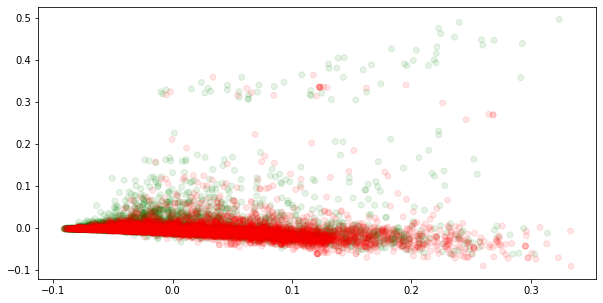

In [17]:
labels = df_kmeans['label']

fig = plt.figure(figsize=(10, 5))
colmap = {0: 'r', 1: 'g'}
colors = list(map(lambda x: colmap[x], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

In 2D, the negative examples (in red) and the positive examples (in green) do not separate well.

In [18]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans

,x1,x2
0,0.030427,0.033787
1,0.007676,-0.008753
2,-0.044828,-0.005224
3,0.035930,-0.006702
4,0.100509,-0.029306
...,...,...
14184,-0.033272,-0.008407
14185,0.098269,-0.017800
14186,-0.039026,-0.003084
14187,-0.011828,-0.010815


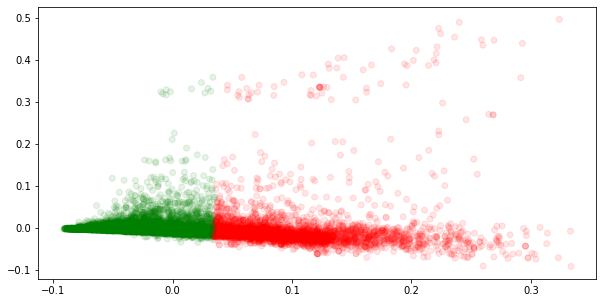

In [19]:
kmeans = KMeans(n_clusters=2, max_iter =300)
kmeans.fit(df_kmeans)

labels = kmeans.predict(df_kmeans)

fig = plt.figure(figsize=(10, 5))
colmap = {1: 'r', 2: 'g'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

Kmeans with 2 clusters does not separate the data well. This was expected as this was done with only the first 2 components from the PCA, which has a very low explained variance of 0.071.

## Sequence Classification using Deep Learning

In [9]:
# Loading data
data = pd.read_csv('../data_instadeep/dna_binding/train.csv')
data.head()

,code,sequence,label,origin
0,Q6A8L0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
1,Q7V7T9,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
2,Q9ZUP2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
3,Q2JVG1,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
4,Q9K4Q3,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...


In [10]:
# add an id column
data["id"] = list(data["code"])
data.head()

,code,sequence,label,origin,id
0,Q6A8L0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q6A8L0
1,Q7V7T9,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q7V7T9
2,Q9ZUP2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q9ZUP2
3,Q2JVG1,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q2JVG1
4,Q9K4Q3,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q9K4Q3


In [11]:
# shuffle the rows
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
data = data.sample(frac=1, random_state=42)
print(data.shape)
data.head(5)

(14189, 5)


,code,sequence,label,origin,id
5646,Q9YEZ5,MADARFYFSDARTWRYMVASIEKIIEEGVFVATGEGLSLRALDTSH...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q9YEZ5
2012,Q24762,MSAAGDAGAGAANGSNNVAVVQATVSVSGNISVGDGSPNNNNNNNA...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q24762
14156,B2V652,MEVITNPGQMQTLMLSLKKQGKKIGFVPTMGYLHEGHLSLIRCSKK...,0,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,B2V652
8852,Q5HWG0,MLEGIVRESIGRKAAKALKRDGYLIANIYGKGLENINAAFKVNEFI...,0,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q5HWG0
12836,Q492D3,MIHGIGIDIVDIRKIKKIITHSGDKLATRILSKSEWKIYKNKKHPV...,0,https://github.com/hfuulgb/PDB-Fusion/tree/mai...,Q492D3


In [12]:


# Data preprocessing
y = np.array(data['label'])

corpus = data.loc[:,['id', 'sequence']]
corpus.columns = ['id', 'sequence']
corpus['sequence'] = corpus['sequence'].map(list)
corpus

,id,sequence
5646,Q9YEZ5,"[M, A, D, A, R, F, Y, F, S, D, A, R, T, W, R, ..."
2012,Q24762,"[M, S, A, A, G, D, A, G, A, G, A, A, N, G, S, ..."
14156,B2V652,"[M, E, V, I, T, N, P, G, Q, M, Q, T, L, M, L, ..."
8852,Q5HWG0,"[M, L, E, G, I, V, R, E, S, I, G, R, K, A, A, ..."
12836,Q492D3,"[M, I, H, G, I, G, I, D, I, V, D, I, R, K, I, ..."
...,...,...
5191,P37947,"[M, K, T, T, I, Y, D, V, A, K, A, A, G, V, S, ..."
13418,B7UFU5,"[M, D, Y, T, L, T, R, I, D, P, N, G, E, N, D, ..."
5390,P37517,"[M, A, N, I, K, E, I, A, R, L, A, N, V, S, V, ..."
860,P37551,"[M, K, F, R, R, S, G, R, L, V, D, L, T, N, Y, ..."


In [13]:
# Sequence embedding
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(corpus)
X = sgtembedding_df.set_index('id')
X

,"(A, A)","(A, B)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, U)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
Q9YEZ5,0.005305,0.0,0.000000e+00,7.571977e-03,0.002361,4.418006e-03,0.001092,4.250390e-04,0.003431,0.003658,...,0.012209,2.542080e-04,1.458001e-04,5.491867e-03,1.212035e-03,0.0,0.003710,9.118820e-04,0.0,7.035400e-03
Q24762,0.004420,0.0,1.212956e-04,1.138610e-03,0.001725,6.241943e-07,0.005321,1.431944e-03,0.000334,0.000836,...,0.003273,1.262761e-03,6.758246e-03,2.762771e-03,2.326822e-03,0.0,0.001040,6.196880e-04,0.0,3.062534e-03
B2V652,0.003173,0.0,1.673164e-04,6.433186e-04,0.007085,4.468059e-03,0.000867,1.230328e-02,0.001185,0.010869,...,0.016129,1.399554e-04,1.750920e-03,3.206581e-03,4.813098e-04,0.0,0.004255,0.000000e+00,0.0,2.222823e-03
Q5HWG0,0.010910,0.0,2.290171e-10,4.016793e-03,0.014802,1.278110e-02,0.007038,2.616520e-03,0.006353,0.006920,...,0.004540,3.065662e-02,3.689886e-11,2.543782e-11,1.673354e-04,0.0,0.001909,0.000000e+00,0.0,4.131254e-04
Q492D3,0.014801,0.0,2.452530e-02,6.276004e-08,0.009239,2.277160e-02,0.006542,8.099842e-06,0.002980,0.020672,...,0.001239,4.690409e-14,4.189004e-05,1.516512e-10,1.022750e-12,0.0,0.001530,0.000000e+00,0.0,3.625141e-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P37947,0.005449,0.0,1.364383e-02,1.982937e-03,0.003668,3.441571e-03,0.004817,2.002861e-03,0.003085,0.004578,...,0.003426,5.060459e-05,5.643111e-07,1.455991e-03,4.209472e-03,0.0,0.002648,0.000000e+00,0.0,2.236418e-05
B7UFU5,0.002504,0.0,1.816482e-02,6.591699e-03,0.004278,9.094619e-03,0.005171,1.353353e-01,0.000657,0.000059,...,0.006618,5.611106e-03,3.655635e-03,6.861267e-03,1.062164e-02,0.0,0.004990,1.863693e-05,0.0,1.114231e-03
P37517,0.005901,0.0,7.221011e-03,4.631948e-03,0.004122,9.011549e-03,0.002151,3.235690e-03,0.003946,0.003118,...,0.005450,7.357923e-03,6.620760e-04,5.510754e-03,5.876884e-03,0.0,0.004891,3.348190e-10,0.0,6.765404e-04


We will perform a 10-fold cross-validation to choose the best model.

In [15]:
kfold = 10
random_state = 1

xval_accuracy = np.zeros(kfold)
xval_recall = np.zeros(kfold)
xval_f1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

models = []
for train_index, xval_index in skf.split(X, y):
    X_train, X_xval = X.iloc[train_index], X.iloc[xval_index]
    y_train, y_xval = y[train_index], y[xval_index]
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],), activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=0)
    models.append(model)
    
    y_pred = model.predict(X_xval).round().astype(int)

    xval_accuracy[k] = sklearn.metrics.accuracy_score(y_xval, y_pred)
    xval_recall[k] = sklearn.metrics.recall_score(y_xval, y_pred)
    xval_f1[k] = sklearn.metrics.f1_score(y_xval, y_pred)
    k+=1
    
print ('Average accuracy score', np.mean(xval_accuracy))
print ('Average recall score', np.mean(xval_recall))
print ('Average f1 score', np.mean(xval_f1))

2022-10-06 00:21:52.476332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


45/45 [==============================] - 0s 3ms/step
Average accuracy score 0.7175976148800631
Average recall score 0.7357805686465619
Average f1 score 0.7233765147211788


For the given problem, accuracy seems like a good metric. With this simple SGT we achieved a 71.5% accuracy.